In [1]:
#Separate notebook to work on Topic Modelling with LDA
%pylab inline
from sys import platform
from pprint import pprint
import pandas as pd
from tqdm import trange

if platform == "win32":
    path = 'C:/Users/olive/'
elif platform == "darwin":
    path = '~/'

Populating the interactive namespace from numpy and matplotlib


In [2]:
c_df = pd.read_pickle(path + 'OneDrive - Cardiff University/Individual Project/processed data/comments.csv')
s_df = pd.read_pickle(path + 'OneDrive - Cardiff University/Individual Project/processed data/submissions.csv')

s_df = s_df.sort_values(by='datetime')
c_df = c_df.sort_values(by='datetime')

In [3]:
comments = c_df.sample(50000)

comments = comments.reset_index().drop(columns=['id', 'datetime', 'sentiment', 'compound_score', 'submission_id', 'parent_id'], axis=1)

comments.head()

,body,processed_text
0,Not at all. I’m still very good friends with p...,not at all i’m still very good friends with pe...
1,I just don't understand why it's being treated...,i just don't understand why it's being treated...
2,First international tournament in 22 years for...,first international tournament in 22 years for...
3,We have a little neighbourhood group but every...,we have a little neighbourhood group but every...
4,They were supposed to do their mock exams next...,they were supposed to do their mock exams next...


In [4]:
# REMOVE EMAILS AND NEWLINE CHARACTERS

data = comments['processed_text'].values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['not at all i’m still very good friends with people from primary secondary '
 'and sixth form and now i have my friends at university nearly all my friends '
 'are through education i can’t imagine how i would know this many good people '
 'without']


/Users/ollyjc/Documents/GitHub/COVID-19-Sentiment-and-Compliance-Analyzer/.venv/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


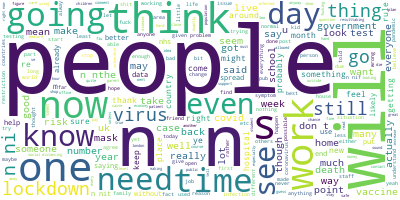

In [104]:
# EXPLORATORY ANALYSIS

from wordcloud import WordCloud

long_string = ','.join(list(comments['processed_text'].values))

wordcloud = WordCloud(background_color="white",
                      max_words=5000,
                      contour_width=3,
                      contour_color='steelblue'
                     )

wordcloud.generate(long_string)

wordcloud.to_image()

In [5]:
# Tokenize words and more text clean-up

import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence),
                                            deacc=True))
        
data_words = list(sent_to_words(data))

print(data_words[:1][0][:30])

['not', 'at', 'all', 'still', 'very', 'good', 'friends', 'with', 'people', 'from', 'primary', 'secondary', 'and', 'sixth', 'form', 'and', 'now', 'have', 'my', 'friends', 'at', 'university', 'nearly', 'all', 'my', 'friends', 'are', 'through', 'education', 'can']


In [6]:
#Bigram and Trigram Phrase Modelling

bigram = gensim.models.Phrases(data_words, 
                               min_count=5, 
                               threshold=100
                              )
trigram = gensim.models.Phrases(bigram[data_words], 
                                threshold=100
                               )

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

print(trigram_mod[bigram_mod[data_words[0]]])

['not', 'at', 'all', 'still', 'very', 'good', 'friends', 'with', 'people', 'from', 'primary', 'secondary', 'and', 'sixth_form', 'and', 'now', 'have', 'my', 'friends', 'at', 'university', 'nearly', 'all', 'my', 'friends', 'are', 'through', 'education', 'can', 'imagine', 'how', 'would', 'know', 'this', 'many', 'good', 'people', 'without']


In [7]:
#Remove Stopwords, Make Bigrams and Lemmantize

import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from',
                   'subject', 
                   're', 
                   'edu', 
                   'use'])

In [8]:
#Define functions for stopwords, bigrams, trigrams and lemmatization

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [9]:
import spacy

data_words_nostops = remove_stopwords(data_words)

data_words_bigrams = make_bigrams(data_words_nostops)

nlp = spacy.load("en_core_web_sm", disable=['parser',
                                            'ner'])

data_lemmatized = lemmatization(data_words_bigrams)

print(data_lemmatized[:1])

[['still', 'good', 'friend', 'people', 'primary', 'secondary', 'sixth_form', 'friend', 'university', 'nearly', 'friend', 'education', 'imagine', 'know', 'many', 'good', 'people']]


In [10]:
#Data Tranformation: Corpus and Dictionary

import gensim.corpora as corpora

id2word = corpora.Dictionary(data_lemmatized)
# id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
# texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[:1])

[[(0, 1), (1, 3), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1)]]


In [11]:
# Building LDA model

def build_lda(num_topics):
    return gensim.models.LdaModel(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=num_topics,
                                  random_state=100,
                                  update_every=1,
                                  chunksize=100,
                                  passes=10,
                                  alpha='auto',
                                  per_word_topics=True)

100%|██████████| 10/10 [20:54<00:00, 125.42s/it]


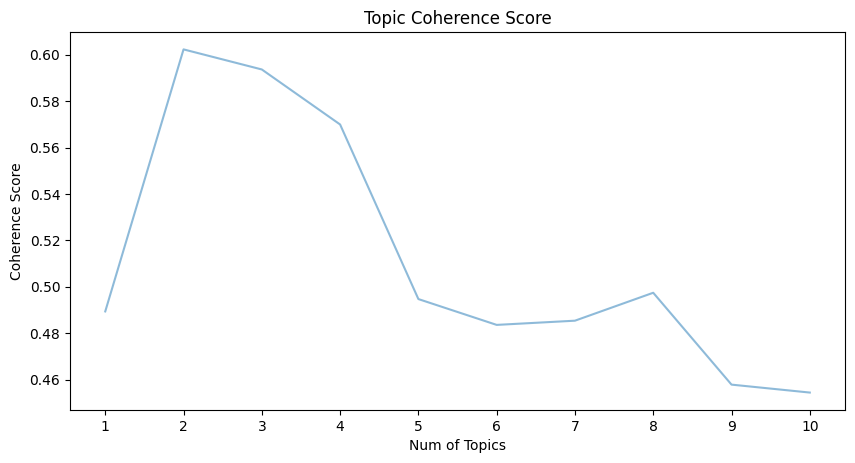

In [12]:
# METHOD FOR TESTING COHERENCE SCORE FOR DIFFERING NUMBERS OF TOPICS

from gensim.models import CoherenceModel

topic_coherence = []
num_topics = 10

for n in trange(1, num_topics + 1):
    
    lda_model = build_lda(n)
    
    # Compute Perplexity
    topic_perplexity = lda_model.log_perplexity(corpus)

    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, 
                                         texts=data_lemmatized, 
                                         dictionary=id2word, 
                                         coherence='c_v')
    
    topic_coherence.append(coherence_model_lda.get_coherence())


x = [i for i in range(1, num_topics + 1)]

fig, ax1 = plt.subplots(1, dpi=100)
fig.set_size_inches(10, 5)

ax1.set_title('Topic Coherence Score')
ax1.set_xlabel('Num of Topics')
ax1.set_ylabel('Coherence Score')
ax1.set_xticks(x)
ax1.plot(x, topic_coherence, alpha=0.5)

In [27]:
import pyLDAvis.gensim_models
import os
import pickle
import pyLDAvis

lda_model = build_lda(8)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model,
                                     corpus,
                                     id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.399523 -0.151118       1        1  21.324677
6     -0.039634  0.426364       2        1  18.028437
5     -0.113424  0.057324       3        1  17.726125
1      0.076897 -0.080259       4        1  10.225807
3      0.134999 -0.099456       5        1   9.942194
2      0.112362 -0.099282       6        1   9.395113
7      0.109559 -0.015375       7        1   7.703386
0      0.118763 -0.038198       8        1   5.654261, topic_info=        Term           Freq          Total Category  logprob  loglift
159       do   99195.000000   99195.000000  Default  30.0000  30.0000
6     people  152355.000000  152355.000000  Default  29.0000  29.0000
73       get  115064.000000  115064.000000  Default  28.0000  28.0000
11        go  102150.000000  102150.000000  Default  27.0000  27.0000
558   school   51057.000000   51057.000000  Default  26.0000  26.0000
...      ...            ...            ...      ...      ...      ...
762      top    3875.099936    3875.954186   Topic8  -4.9545   2.8725
835    offer    3871.629833    3872.484755   Topic8  -4.9554   2.8725
2866  option    3866.805825    3867.660051   Topic8  -4.9566   2.8725
834   future    3514.929084    3515.783335   Topic8  -5.0520   2.8725
641    doubt    3508.043383    3508.897615   Topic8  -5.0540   2.8725

[271 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1210      2  0.999946       able
348       3  0.999968   actually
2246      6  0.999918        age
70        3  0.999947      agree
493       1  0.999934    already
...     ...       ...        ...
1023      8  0.999767     worker
8         7  0.999862      worry
912       3  0.999883      wrong
297       4  0.999969       year
563       4  0.999873  yesterday

[242 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 7, 6, 2, 4, 3, 8, 1])